In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, utils

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
from PIL import Image
import time
import os
import copy
from collections import Counter

In [2]:
tabular_data = "../../data/SkidSteer_2019-08.csv"

df = pd.read_csv(tabular_data, index_col=1)
df['Unique_ID'] = df[['Source','item#']].apply(lambda x: '_'.join(x),axis = 1)
df = df.filter(['Unique_ID','Winning Bid','Hours Final','Age at Sale (bin)','Bucket','Engine','Tires','Transmission'], axis = 1)
df = df.rename(columns={
    'Unique_ID': "unique_id",
    'Hours Final': "hours_final",
    'Winning Bid': "winning_bid",
    'Age at Sale (bin)': "age_at_sale",
    'Bucket': "bucket",
    'Engine': "engine",
    'Tires': "tires",
    'Transmission': "transmission"
})
# color = pd.read_csv('skid_steer_color_score.csv')
# final_df = pd.merge(new_df, color,on='Unique_ID',how='inner')


### removal
# remove duplicant
duplicated_item = [item for item, count in Counter(df["unique_id"]).items() if count > 1]
df = df[~df['unique_id'].isin(duplicated_item)]

# remove not matched rows
image_item = [img_name.strip(".jpg") for img_name in os.listdir("../../data/images/")]
df = df[df["unique_id"].isin(image_item)]

# remove comma
df["winning_bid"] = df["winning_bid"].str.replace(',', '').astype(int)

# remove special image
df = df[df['unique_id'] != "rbauction_10525632"]

In [3]:
### winning_bid

# log-transform
df["winning_bid"] = np.log(df["winning_bid"])

# min max scale
mm_scaler_price = preprocessing.MinMaxScaler((-1, 1))
df["winning_bid"] = mm_scaler_price.fit_transform(df["winning_bid"].to_numpy().reshape(-1, 1))

In [4]:
### hours_final

# impute nan with median and new binary indicator
df["hours_final"] = df["hours_final"].str.replace(",", "")
df["hours_final"] = df["hours_final"].astype(float)
df.insert(3, column="hours_final_nan", value=df["hours_final"].isna().astype(int))
df.loc[df["hours_final"].isna(), "hours_final"] = df["hours_final"].median(skipna=True)

# log transform
df["hours_final"] = np.log(df["hours_final"])

# normalize
rb_scaler_hour = preprocessing.RobustScaler()
df["hours_final"] = rb_scaler_hour.fit_transform(np.array(df["hours_final"]).reshape(-1, 1))

In [5]:
### age_at_sale

# impute nan with median and new binary indicator
df["age_at_sale"] = df["age_at_sale"].astype(float)
df.insert(5, column="age_at_sale_nan", value=df["age_at_sale"].isna().astype(int))
df.loc[df["age_at_sale"].isna(), "age_at_sale"] = df["age_at_sale"].median(skipna=True)

# normalize
rb_scaler_age = preprocessing.RobustScaler()
df["age_at_sale"] = rb_scaler_age.fit_transform(np.array(df["age_at_sale"]).reshape(-1, 1))

In [6]:
### bucket
df.insert(7, column="bucket_bin", value=0)
df.loc[
    ~df["bucket"].isna() & 
    df["bucket"].str.contains("bucket", case=False) | 
    df["bucket"].str.contains("bkt", case=False), "bucket_bin"
] = 1

In [7]:
# shuffle and split
np.random.seed(1)
split = [0.7, 0.3]
split0 = round(df.shape[0] * split[0])
# split1 = round(df.shape[0] * (split[0] + split[1]))
df = df.sample(frac=1)
df_train = df.iloc[:split0]
df_val = df.iloc[split0:]

In [8]:
df_train.head()

,unique_id,winning_bid,hours_final,hours_final_nan,age_at_sale,age_at_sale_nan,bucket,bucket_bin,engine,tires,transmission
Item Id,,,,,,,,,,,
ec1907ce-5c12-5ab8-b42d-39eb481e6049,ironplanet_1703726,0.105406,-6.732824,0,-0.666667,0,"74"" Wide General Purpose Smooth Edge Bucket",1,NaN,Cushion Tires,NaN
529071,PW_DD1289,0.172815,-1.629216,0,-1.000000,0,"Kubota 68""W bucket",1,Kubota V3307-CR four cylinder turbo diesel engine,Titan 12-16.5 NHS tires,Two speed hydrostatic transmission
eff85cf8-4988-8990-b317-39e91a64ec3a,rbauction_10239624,0.219707,-0.164164,0,-0.666667,0,hyd Q/C bkt,1,NaN,NaN,NaN
386158,PW_H1380,-0.072566,-0.769452,0,-0.333333,0,"80""W bucket",1,"81 HP, Case 3.2L four cylinder turbo diesel en...",12-16.5 tires,Hydrostatic transmission
460813,PW_J8873,-0.305592,-0.416323,0,-0.333333,0,NaN,0,John Deere 5030TT001 3.0L turbo diesel engine,12-16.5 tires,Two speed hydrostatic transmission


In [9]:
df_val.head()

,unique_id,winning_bid,hours_final,hours_final_nan,age_at_sale,age_at_sale_nan,bucket,bucket_bin,engine,tires,transmission
Item Id,,,,,,,,,,,
cdf26f3a-f792-7a0f-350e-39e9461c54c9,bigiron_EN9531,0.164709,-0.503074,0,-0.333333,0,"84"" Bucket",1,"4-Cyl Turbo Diesel Engine, 84 Hp","Some Tires Have Cuts (Pictured), Tires- 14-17....",NaN
14c666d4-512a-8962-6072-39e918e5b2f7,rbauction_10693873,-0.861828,-0.443163,0,1.333333,0,bkt,1,NaN,NaN,NaN
dc20ac44-7c35-11a7-2dfa-39e8cc01c274,bigiron_BO0203,-0.180158,-0.226316,0,1.333333,0,"Buckets 12"", 64"" Bucket",1,58 Horse Power Isuzu Diesel Engine,"12-16.5 Tires, Spare Tire And Rim",Hydrostat Transmission
ebfb5935-40e0-4488-2e6c-39ea98658096,ironplanet_1891010,-0.402470,-6.732824,0,-0.333333,0,"72"" Wide General Purpose Smooth Edge Bucket",1,NaN,NaN,NaN
446849,PW_J2936,-0.402470,-1.926828,0,-0.333333,0,NaN,0,"Case four cylinder turbo diesel engine, Non-op...",12-16.5 tires,Hydrostatic transmission


In [10]:
df_train.to_csv("./SkidSteer_2019-08_clean_train.csv")
df_val.to_csv("./SkidSteer_2019-08_clean_val.csv")

In [11]:
class skidsteer_dataset(Dataset):
    """Corrosion Detection dataset."""

    def __init__(self, 
                 csv_file, 
                 img_root, 
                 transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            img_root (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample (including augmentation).
        """
        self.csv_file = pd.read_csv(csv_file, index_col=0)
        self.img_root = img_root
        self.transform = transform

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):
        '''Return one data point with a PIL image and its label.'''
        img_dir = os.path.join(self.img_root, self.csv_file["unique_id"][idx]) + ".jpg"
        price = self.csv_file["winning_bid"][idx]
        image = Image.open(img_dir)
        others = torch.tensor(self.csv_file.iloc[idx, [2, 3, 4, 5, 7]])
        
        if self.transform:
            image = self.transform(image)
        sample = {'image': image, 'price': price, "others": others}
        return sample

In [12]:
def norm2price(tensor, min_max_scaler):
    array2d = tensor.to("cpu").data.numpy().reshape(-1, 1)
    return np.exp(min_max_scaler.inverse_transform(array2d))

def price_MAE(outputs, prices, min_max_scaler):
    outputs = norm2price(outputs, min_max_scaler)
    prices = norm2price(prices, min_max_scaler)
    mae = np.abs(outputs - prices)
    return mae.mean(), mae

In [13]:
def train_model(model, model_LU, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch = None
    best_loss = float("Inf")
    best_mae = float("Inf")
    best_mae_list = None

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_mae = 0.0
            running_mae_list = []
            
            # Iterate over data.
            for items in dataloaders[phase]:
                images = items["image"].to(device)
                prices = items["price"].to(device)
                others = items["others"].to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = cat_net(model, model_LU, images, others).squeeze()
                    loss = criterion(outputs, prices)
                    mae, mae_np = price_MAE(outputs, prices, mm_scaler_price)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * images.size(0)
                running_mae += mae * images.size(0)
                running_mae_list += list(mae_np.flatten())
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_mae = running_mae / dataset_sizes[phase]
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            print('{} MAE: {:.4f}'.format(phase, epoch_mae))
            
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_epoch = epoch + 1
                best_loss = epoch_loss
                best_mae = epoch_mae
                best_mae_list = running_mae_list
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f} at epoch {}'.format(best_loss, best_epoch))
    print('Best val MAE: {:4f} at epoch {}'.format(best_mae, best_epoch))

    # load best model weights
    print("\nLoad the model weights at the best epoch")
    model.load_state_dict(best_model_wts)
    return model, best_mae_list

In [14]:
CSV_FILE = {"train": "./SkidSteer_2019-08_clean_train.csv",
            "val": "./SkidSteer_2019-08_clean_val.csv"}
IMG_ROOT = "../../data/images/"
TRANSFORM = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

datasets = {x: skidsteer_dataset(csv_file=CSV_FILE[x],
                                 img_root=IMG_ROOT,
                                 transform=TRANSFORM[x])
            for x in ["train", "val"]}
dataloaders = {x: DataLoader(datasets[x], 
                             batch_size=16, 
                             shuffle=True, 
                             num_workers=4)
               for x in ["train", "val"]}
dataset_sizes = {x: len(datasets[x]) for x in ["train", "val"]}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
def cat_net(model, model_LU, images, others):
    z = torch.cat((model(images), others), dim=1)
    return model_LU(z)

## (2053, 1) + CB3+

In [16]:
torch.manual_seed(0)

### ResNet18
model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Identity()

### Freeze and Fine Tuning
for param in model_ft.parameters():
    param.requires_grad = False
for param in model_ft.layer3.parameters():
    param.requires_grad = True
for param in model_ft.layer4.parameters():
    param.requires_grad = True
assert [param.requires_grad for param in model_ft.parameters()][-1]

### LU
model_LU = nn.Sequential(
    nn.Linear(num_ftrs + 5, 1)
)

### model setup
model_ft = model_ft.to(device)
model_LU = model_LU.to(device)
criterion = nn.MSELoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(list(model_ft.parameters())+list(model_LU.parameters()), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)

In [17]:
model_res152, mae_list_0 = train_model(model_ft, model_LU, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

Epoch 1/100
----------
train Loss: 0.1017
train MAE: 4810.7604
val Loss: 0.0563
val MAE: 3410.0144

Epoch 2/100
----------
train Loss: 0.0703
train MAE: 3965.6556
val Loss: 0.0551
val MAE: 3485.2092

Epoch 3/100
----------
train Loss: 0.0878
train MAE: 4527.2749
val Loss: 0.2787
val MAE: 12098.5497

Epoch 4/100
----------
train Loss: 0.0680
train MAE: 3939.6814
val Loss: 0.0526
val MAE: 3458.2348

Epoch 5/100
----------
train Loss: 0.0780
train MAE: 4222.8610
val Loss: 0.0537
val MAE: 3397.6450

Epoch 6/100
----------
train Loss: 0.0599
train MAE: 3691.8909
val Loss: 0.0431
val MAE: 2962.5277

Epoch 7/100
----------
train Loss: 0.0593
train MAE: 3677.7435
val Loss: 0.0449
val MAE: 2995.4634

Epoch 8/100
----------
train Loss: 0.0624
train MAE: 3789.3490
val Loss: 0.0396
val MAE: 2867.0919

Epoch 9/100
----------
train Loss: 0.0656
train MAE: 3922.9481
val Loss: 0.0581
val MAE: 3817.4006

Epoch 10/100
----------
train Loss: 0.0539
train MAE: 3480.5385
val Loss: 0.0585
val MAE: 3741.6139

## (2053, 32, 1) + CB3+

In [18]:
torch.manual_seed(0)

### ResNet18
model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Identity()

### Freeze and Fine Tuning
for param in model_ft.parameters():
    param.requires_grad = False
for param in model_ft.layer3.parameters():
    param.requires_grad = True
for param in model_ft.layer4.parameters():
    param.requires_grad = True
assert [param.requires_grad for param in model_ft.parameters()][-1]

### LU
model_LU = nn.Sequential(
    nn.Linear(num_ftrs + 5, 32),
    nn.Tanh(), 
    nn.Linear(32, 1)
)

### model setup
model_ft = model_ft.to(device)
model_LU = model_LU.to(device)
criterion = nn.MSELoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(list(model_ft.parameters())+list(model_LU.parameters()), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)

In [19]:
model_res152, mae_list_1 = train_model(model_ft, model_LU, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

Epoch 1/100
----------
train Loss: 0.0817
train MAE: 4303.2025
val Loss: 0.0491
val MAE: 3253.5203

Epoch 2/100
----------
train Loss: 0.0575
train MAE: 3599.3650
val Loss: 0.0438
val MAE: 3051.9073

Epoch 3/100
----------
train Loss: 0.0521
train MAE: 3432.8679
val Loss: 0.0416
val MAE: 2959.5806

Epoch 4/100
----------
train Loss: 0.0495
train MAE: 3323.0131
val Loss: 0.0401
val MAE: 2916.4873

Epoch 5/100
----------
train Loss: 0.0462
train MAE: 3195.9595
val Loss: 0.0412
val MAE: 2934.3668

Epoch 6/100
----------
train Loss: 0.0479
train MAE: 3240.5021
val Loss: 0.0464
val MAE: 3173.1066

Epoch 7/100
----------
train Loss: 0.0428
train MAE: 3102.8771
val Loss: 0.0372
val MAE: 2810.6604

Epoch 8/100
----------
train Loss: 0.0434
train MAE: 3094.2295
val Loss: 0.0399
val MAE: 2903.9555

Epoch 9/100
----------
train Loss: 0.0404
train MAE: 2982.6758
val Loss: 0.0366
val MAE: 2747.8979

Epoch 10/100
----------
train Loss: 0.0410
train MAE: 3027.5436
val Loss: 0.0362
val MAE: 2736.8537


## (2053, 64, 1) + CB3+

In [20]:
torch.manual_seed(0)

### ResNet18
model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Identity()

### Freeze and Fine Tuning
for param in model_ft.parameters():
    param.requires_grad = False
for param in model_ft.layer3.parameters():
    param.requires_grad = True
for param in model_ft.layer4.parameters():
    param.requires_grad = True
assert [param.requires_grad for param in model_ft.parameters()][-1]

### LU
model_LU = nn.Sequential(
    nn.Linear(num_ftrs + 5, 64),
    nn.Tanh(), 
    nn.Linear(64, 1)
)

### model setup
model_ft = model_ft.to(device)
model_LU = model_LU.to(device)
criterion = nn.MSELoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(list(model_ft.parameters())+list(model_LU.parameters()), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)

In [21]:
model_res152, mae_list_3 = train_model(model_ft, model_LU, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

Epoch 1/100
----------
train Loss: 0.0868
train MAE: 4330.9425
val Loss: 0.0525
val MAE: 3390.0677

Epoch 2/100
----------
train Loss: 0.0599
train MAE: 3681.5374
val Loss: 0.0506
val MAE: 3322.0110

Epoch 3/100
----------
train Loss: 0.0543
train MAE: 3501.1198
val Loss: 0.0422
val MAE: 3008.1626

Epoch 4/100
----------
train Loss: 0.0495
train MAE: 3325.8292
val Loss: 0.0434
val MAE: 3025.7609

Epoch 5/100
----------
train Loss: 0.0479
train MAE: 3276.5011
val Loss: 0.0417
val MAE: 2998.6961

Epoch 6/100
----------
train Loss: 0.0449
train MAE: 3159.5737
val Loss: 0.0423
val MAE: 3035.4299

Epoch 7/100
----------
train Loss: 0.0443
train MAE: 3155.7754
val Loss: 0.0392
val MAE: 2887.9100

Epoch 8/100
----------
train Loss: 0.0430
train MAE: 3087.6443
val Loss: 0.0364
val MAE: 2769.4753

Epoch 9/100
----------
train Loss: 0.0423
train MAE: 3059.4740
val Loss: 0.0353
val MAE: 2729.5608

Epoch 10/100
----------
train Loss: 0.0393
train MAE: 2932.4462
val Loss: 0.0476
val MAE: 3144.5031


## (2053, 256, 1) + CB3+

In [22]:
torch.manual_seed(0)

### ResNet18
model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Identity()

### Freeze and Fine Tuning
for param in model_ft.parameters():
    param.requires_grad = False
for param in model_ft.layer3.parameters():
    param.requires_grad = True
for param in model_ft.layer4.parameters():
    param.requires_grad = True
assert [param.requires_grad for param in model_ft.parameters()][-1]

### LU
model_LU = nn.Sequential(
    nn.Linear(num_ftrs + 5, 256),
    nn.Tanh(), 
    nn.Linear(256, 1)
)

### model setup
model_ft = model_ft.to(device)
model_LU = model_LU.to(device)
criterion = nn.MSELoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(list(model_ft.parameters())+list(model_LU.parameters()), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)

In [23]:
model_res152, mae_list_5 = train_model(model_ft, model_LU, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

Epoch 1/100
----------
train Loss: 0.0857
train MAE: 4303.8513
val Loss: 0.0544
val MAE: 3464.2085

Epoch 2/100
----------
train Loss: 0.0597
train MAE: 3653.8600
val Loss: 0.0499
val MAE: 3228.5116

Epoch 3/100
----------
train Loss: 0.0543
train MAE: 3466.7035
val Loss: 0.0412
val MAE: 2954.0585

Epoch 4/100
----------
train Loss: 0.0496
train MAE: 3364.3578
val Loss: 0.0404
val MAE: 2936.5862

Epoch 5/100
----------
train Loss: 0.0470
train MAE: 3254.8241
val Loss: 0.0377
val MAE: 2817.6215

Epoch 6/100
----------
train Loss: 0.0442
train MAE: 3152.6217
val Loss: 0.0402
val MAE: 2903.2326

Epoch 7/100
----------
train Loss: 0.0457
train MAE: 3203.7513
val Loss: 0.0454
val MAE: 3115.4586

Epoch 8/100
----------
train Loss: 0.0424
train MAE: 3059.0936
val Loss: 0.0355
val MAE: 2740.7619

Epoch 9/100
----------
train Loss: 0.0437
train MAE: 3108.1404
val Loss: 0.0372
val MAE: 2800.2737

Epoch 10/100
----------
train Loss: 0.0415
train MAE: 3035.0524
val Loss: 0.0356
val MAE: 2754.1853


## (2053, 32, 1) + DO + CB3+

In [24]:
torch.manual_seed(0)

### ResNet18
model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Identity()

### Freeze and Fine Tuning
for param in model_ft.parameters():
    param.requires_grad = False
for param in model_ft.layer3.parameters():
    param.requires_grad = True
for param in model_ft.layer4.parameters():
    param.requires_grad = True
assert [param.requires_grad for param in model_ft.parameters()][-1]

### LU
model_LU = nn.Sequential(
    nn.Linear(num_ftrs + 5, 32),
    nn.Tanh(), 
    nn.Dropout(p=0.4),
    nn.Linear(32, 1)
)

### model setup
model_ft = model_ft.to(device)
model_LU = model_LU.to(device)
criterion = nn.MSELoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(list(model_ft.parameters())+list(model_LU.parameters()), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)

In [25]:
model_res152, mae_list_2 = train_model(model_ft, model_LU, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

Epoch 1/100
----------
train Loss: 0.0943
train MAE: 4596.5484
val Loss: 0.0562
val MAE: 3475.2613

Epoch 2/100
----------
train Loss: 0.0643
train MAE: 3780.7022
val Loss: 0.0517
val MAE: 3285.6866

Epoch 3/100
----------
train Loss: 0.0585
train MAE: 3619.5315
val Loss: 0.0482
val MAE: 3170.3074

Epoch 4/100
----------
train Loss: 0.0549
train MAE: 3517.7332
val Loss: 0.0469
val MAE: 3127.5215

Epoch 5/100
----------
train Loss: 0.0524
train MAE: 3397.6696
val Loss: 0.0442
val MAE: 3059.9985

Epoch 6/100
----------
train Loss: 0.0517
train MAE: 3360.8065
val Loss: 0.0485
val MAE: 3218.7589

Epoch 7/100
----------
train Loss: 0.0484
train MAE: 3301.4213
val Loss: 0.0452
val MAE: 3099.9392

Epoch 8/100
----------
train Loss: 0.0465
train MAE: 3195.0921
val Loss: 0.0410
val MAE: 2907.3924

Epoch 9/100
----------
train Loss: 0.0443
train MAE: 3123.7097
val Loss: 0.0396
val MAE: 2895.5838

Epoch 10/100
----------
train Loss: 0.0446
train MAE: 3166.7866
val Loss: 0.0406
val MAE: 2907.8046


## (2053, 64, 1) + DO + CB3+

In [26]:
torch.manual_seed(0)

### ResNet18
model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Identity()

### Freeze and Fine Tuning
for param in model_ft.parameters():
    param.requires_grad = False
for param in model_ft.layer3.parameters():
    param.requires_grad = True
for param in model_ft.layer4.parameters():
    param.requires_grad = True
assert [param.requires_grad for param in model_ft.parameters()][-1]

### LU
model_LU = nn.Sequential(
    nn.Linear(num_ftrs + 5, 64),
    nn.Tanh(), 
    nn.Dropout(p=0.4),
    nn.Linear(64, 1)
)

### model setup
model_ft = model_ft.to(device)
model_LU = model_LU.to(device)
criterion = nn.MSELoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(list(model_ft.parameters())+list(model_LU.parameters()), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)

In [27]:
model_res152, mae_list_4 = train_model(model_ft, model_LU, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

Epoch 1/100
----------
train Loss: 0.0986
train MAE: 4580.7431
val Loss: 0.0671
val MAE: 3909.1609

Epoch 2/100
----------
train Loss: 0.0674
train MAE: 3876.8607
val Loss: 0.0517
val MAE: 3358.9410

Epoch 3/100
----------
train Loss: 0.0595
train MAE: 3648.0643
val Loss: 0.0508
val MAE: 3311.5708

Epoch 4/100
----------
train Loss: 0.0537
train MAE: 3445.9775
val Loss: 0.0447
val MAE: 3069.0476

Epoch 5/100
----------
train Loss: 0.0522
train MAE: 3393.5715
val Loss: 0.0527
val MAE: 3397.2014

Epoch 6/100
----------
train Loss: 0.0488
train MAE: 3286.1721
val Loss: 0.0426
val MAE: 3012.8017

Epoch 7/100
----------
train Loss: 0.0468
train MAE: 3228.0724
val Loss: 0.0423
val MAE: 2963.2726

Epoch 8/100
----------
train Loss: 0.0470
train MAE: 3194.6751
val Loss: 0.0393
val MAE: 2887.9360

Epoch 9/100
----------
train Loss: 0.0468
train MAE: 3185.1937
val Loss: 0.0399
val MAE: 2901.8096

Epoch 10/100
----------
train Loss: 0.0436
train MAE: 3096.1859
val Loss: 0.0399
val MAE: 2867.3746


## (2053, 256, 1) + DO + CB3+

In [16]:
torch.manual_seed(0)

### ResNet18
model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Identity()

### Freeze and Fine Tuning
for param in model_ft.parameters():
    param.requires_grad = False
for param in model_ft.layer3.parameters():
    param.requires_grad = True
for param in model_ft.layer4.parameters():
    param.requires_grad = True
assert [param.requires_grad for param in model_ft.parameters()][-1]

### LU
model_LU = nn.Sequential(
    nn.Linear(num_ftrs + 5, 256),
    nn.Tanh(), 
    nn.Dropout(p=0.4),
    nn.Linear(256, 1)
)

### model setup
model_ft = model_ft.to(device)
model_LU = model_LU.to(device)
criterion = nn.MSELoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(list(model_ft.parameters())+list(model_LU.parameters()), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)

In [17]:
model_res152, mae_list_6 = train_model(model_ft, model_LU, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

Epoch 1/100
----------
train Loss: 0.0964
train MAE: 4536.6060
val Loss: 0.0550
val MAE: 3465.9310

Epoch 2/100
----------
train Loss: 0.0640
train MAE: 3801.8644
val Loss: 0.0479
val MAE: 3255.9154

Epoch 3/100
----------
train Loss: 0.0568
train MAE: 3565.2622
val Loss: 0.0465
val MAE: 3116.8081

Epoch 4/100
----------
train Loss: 0.0528
train MAE: 3427.7877
val Loss: 0.0421
val MAE: 2990.6768

Epoch 5/100
----------
train Loss: 0.0493
train MAE: 3347.8585
val Loss: 0.0393
val MAE: 2914.2692

Epoch 6/100
----------
train Loss: 0.0464
train MAE: 3210.2689
val Loss: 0.0438
val MAE: 3059.7734

Epoch 7/100
----------
train Loss: 0.0478
train MAE: 3252.4334
val Loss: 0.0392
val MAE: 2905.5526

Epoch 8/100
----------
train Loss: 0.0446
train MAE: 3146.4938
val Loss: 0.0433
val MAE: 3020.4330

Epoch 9/100
----------
train Loss: 0.0452
train MAE: 3163.6701
val Loss: 0.0382
val MAE: 2834.1482

Epoch 10/100
----------
train Loss: 0.0436
train MAE: 3102.0383
val Loss: 0.0410
val MAE: 2897.2842


## Residual Analysis

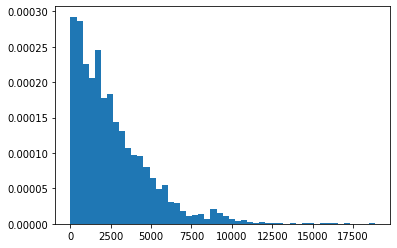

In [26]:
plt.hist(mae_list_6, bins=50, density=True)
plt.show()

In [45]:
np.mean(mae_list_6), np.median(mae_list_6), len(mae_list_6)

(2653.148, 2005.1562, 1850)

In [46]:
thres = 5000
print("%.2f%%" % (sum(np.array(mae_list_6) < thres) / len(mae_list_6) * 100))

86.32%
